In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2
from scipy.spatial.distance import mahalanobis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('./data/beer_profile_and_ratings.csv')

print("Первые 5 строк данных:")
print(df.head())
print("\nИнформация о данных:")
df.info()

Первые 5 строк данных:
                           Name    Style  \
0                         Amber  Altbier   
1                    Double Bag  Altbier   
2                Long Trail Ale  Altbier   
3                  Doppelsticke  Altbier   
4  Sleigh'r Dark Doüble Alt Ale  Altbier   

                                            Brewery  \
0                               Alaskan Brewing Co.   
1                            Long Trail Brewing Co.   
2                            Long Trail Brewing Co.   
3  Uerige Obergärige Hausbrauerei GmbH / Zum Uerige   
4                           Ninkasi Brewing Company   

                                    Beer Name (Full)  \
0                  Alaskan Brewing Co. Alaskan Amber   
1                  Long Trail Brewing Co. Double Bag   
2              Long Trail Brewing Co. Long Trail Ale   
3  Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...   
4  Ninkasi Brewing Company Sleigh'r Dark Doüble A...   

                                         Des

In [3]:
feature_cols = ['ABV', 'Min IBU', 'Max IBU', 'Astringency', 'Body', 'Alcohol',
                'Bitter', 'Sweet', 'Sour', 'Salty', 'Fruits', 'Hoppy',
                'Spices', 'Malty', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste']
target_col = 'review_overall'

df_subset = df[feature_cols + [target_col]].copy()

initial_rows = df_subset.shape[0]
df_subset.dropna(inplace=True)
final_rows = df_subset.shape[0]
print(f"\nОбработка пропущенных значений: Удалено {initial_rows - final_rows} строк.")
print(f"Размер данных после удаления пропусков: {df_subset.shape}")

X = df_subset[feature_cols]
y = df_subset[target_col]

print("\nВыбранные признаки (X):")
print(X.head())
print("\nЦелевая переменная (y):")
print(y.head())
print("\nОсновная статистика признаков:")
print(X.describe())


Обработка пропущенных значений: Удалено 0 строк.
Размер данных после удаления пропусков: (3197, 19)

Выбранные признаки (X):
   ABV  Min IBU  Max IBU  Astringency  Body  Alcohol  Bitter  Sweet  Sour  \
0  5.3       25       50           13    32        9      47     74    33   
1  7.2       25       50           12    57       18      33     55    16   
2  5.0       25       50           14    37        6      42     43    11   
3  8.5       25       50           13    55       31      47    101    18   
4  7.2       25       50           25    51       26      44     45     9   

   Salty  Fruits  Hoppy  Spices  Malty  review_aroma  review_appearance  \
0      0      33     57       8    111      3.498994           3.636821   
1      0      24     35      12     84      3.798337           3.846154   
2      0      10     54       4     62      3.409814           3.667109   
3      1      49     40      16    119      4.148098           4.033967   
4      1      11     51      20     

In [4]:
X_np = X.values

try:
    cov_matrix = np.cov(X_np.T)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    mean_vec = np.mean(X_np, axis=0)

    diff = X_np - mean_vec
    
    mahalanobis_sq = np.einsum('ij,jk,ik->i', diff, inv_cov_matrix, diff)
    mahalanobis_dist = np.sqrt(mahalanobis_sq)

    df_chi2 = X_np.shape[1]
    alpha = 0.05
    threshold = chi2.ppf(1 - alpha, df=df_chi2)

    outlier_indices = np.where(mahalanobis_sq > threshold)[0]
    print(f"Порог Махаланобиса (Chi2, df={df_chi2}, alpha={alpha}): {threshold:.4f}")
    print(f"Количество обнаруженных выбросов: {len(outlier_indices)}")

    X_filtered = X.drop(X.index[outlier_indices]).reset_index(drop=True)
    y_filtered = y.drop(y.index[outlier_indices]).reset_index(drop=True)

    print(f"Размер до удаления выбросов: X={X.shape}, y={y.shape}")
    print(f"Размер после удаления выбросов: X={X_filtered.shape}, y={y_filtered.shape}")

    print("\nСтатистика признаков ПОСЛЕ удаления выбросов:")
    print(X_filtered.describe())

except np.linalg.LinAlgError:
    print("Ошибка: Не удалось вычислить обратную матрицу ковариации (вырожденная матрица).")
    print("Пропуск удаления выбросов. Используются исходные данные.")
    X_filtered = X.copy()
    y_filtered = y.copy()
except Exception as e:
    print(f"Ошибка при удалении выбросов: {e}")
    print("Пропуск удаления выбросов. Используются исходные данные.")
    X_filtered = X.copy()
    y_filtered = y.copy()

Порог Махаланобиса (Chi2, df=18, alpha=0.05): 28.8693
Количество обнаруженных выбросов: 445
Размер до удаления выбросов: X=(3197, 18), y=(3197,)
Размер после удаления выбросов: X=(2752, 18), y=(2752,)

Статистика признаков ПОСЛЕ удаления выбросов:
               ABV      Min IBU      Max IBU  Astringency         Body  \
count  2752.000000  2752.000000  2752.000000  2752.000000  2752.000000   
mean      6.374622    21.707849    38.538881    16.349927    45.599927   
std       2.094802    12.832692    20.204479     9.283139    24.332204   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       5.000000    15.000000    25.000000    10.000000    29.000000   
50%       5.800000    20.000000    35.000000    15.000000    40.000000   
75%       7.500000    25.000000    45.000000    21.250000    57.000000   
max      16.300000    65.000000   100.000000    56.000000   154.000000   

          Alcohol       Bitter        Sweet         Sour        Salty  \
count  2752.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)
print(f"Размер обучающей выборки: {X_train.shape[0]} образцов")
print(f"Размер тестовой выборки: {X_test.shape[0]} образцов")

print("\n--- 4. Полиномиальная регрессия ---")

degrees = range(1, 5)
results = []

for degree in degrees:
    print(f"\nОбучение полиномиальной регрессии степени={degree}")

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly_features', PolynomialFeatures(degree=degree, include_bias=False)),
        ('lin_reg', LinearRegression())
    ])

    pipeline.fit(X_train, y_train)

    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"  MSE на обучении: {train_mse:.4f}, R2 на обучении: {train_r2:.4f}")
    print(f"  MSE на тесте:    {test_mse:.4f}, R2 на тесте:    {test_r2:.4f}")

    results.append({
        'degree': degree,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'model': pipeline
    })

results_df = pd.DataFrame(results)

Размер обучающей выборки: 2201 образцов
Размер тестовой выборки: 551 образцов

--- 4. Полиномиальная регрессия ---

Обучение полиномиальной регрессии степени=1


  MSE на обучении: 0.0147, R2 на обучении: 0.9158
  MSE на тесте:    0.0117, R2 на тесте:    0.9348

Обучение полиномиальной регрессии степени=2
  MSE на обучении: 0.0115, R2 на обучении: 0.9342
  MSE на тесте:    0.0116, R2 на тесте:    0.9356

Обучение полиномиальной регрессии степени=3
  MSE на обучении: 0.0031, R2 на обучении: 0.9822
  MSE на тесте:    0.0641, R2 на тесте:    0.6423

Обучение полиномиальной регрессии степени=4
  MSE на обучении: 0.0000, R2 на обучении: 1.0000
  MSE на тесте:    0.3217, R2 на тесте:    -0.7938


   degree     train_mse  test_mse  train_r2   test_r2
0       1  1.468212e-02  0.011692  0.915775  0.934810
1       2  1.147710e-02  0.011553  0.934161  0.935583
2       3  3.111605e-03  0.064149  0.982150  0.642319
3       4  9.034095e-29  0.321709  1.000000 -0.793769


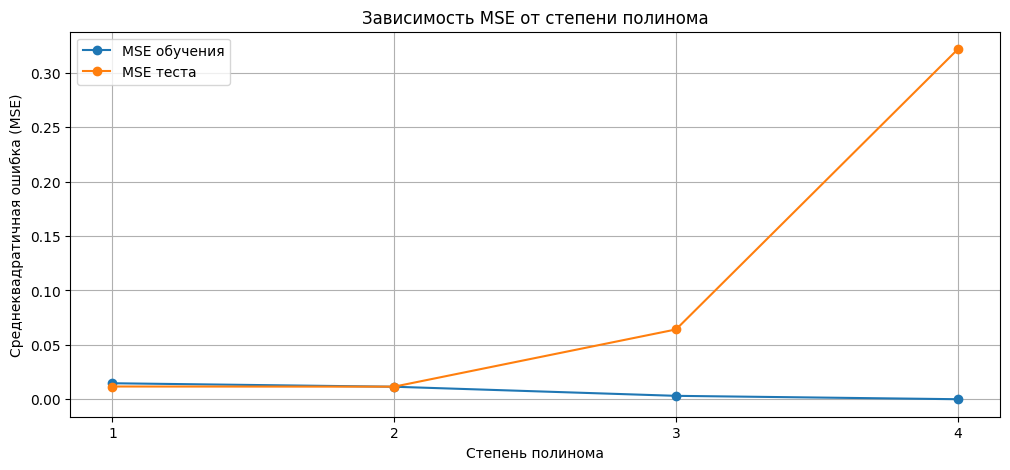

In [6]:
print(results_df[['degree', 'train_mse', 'test_mse', 'train_r2', 'test_r2']])

plt.figure(figsize=(12, 5))
plt.plot(results_df['degree'], results_df['train_mse'], marker='o', label='MSE обучения')
plt.plot(results_df['degree'], results_df['test_mse'], marker='o', label='MSE теста')
plt.xlabel('Степень полинома')
plt.ylabel('Среднеквадратичная ошибка (MSE)')
plt.title('Зависимость MSE от степени полинома')
plt.xticks(degrees)
plt.legend()
plt.grid(True)

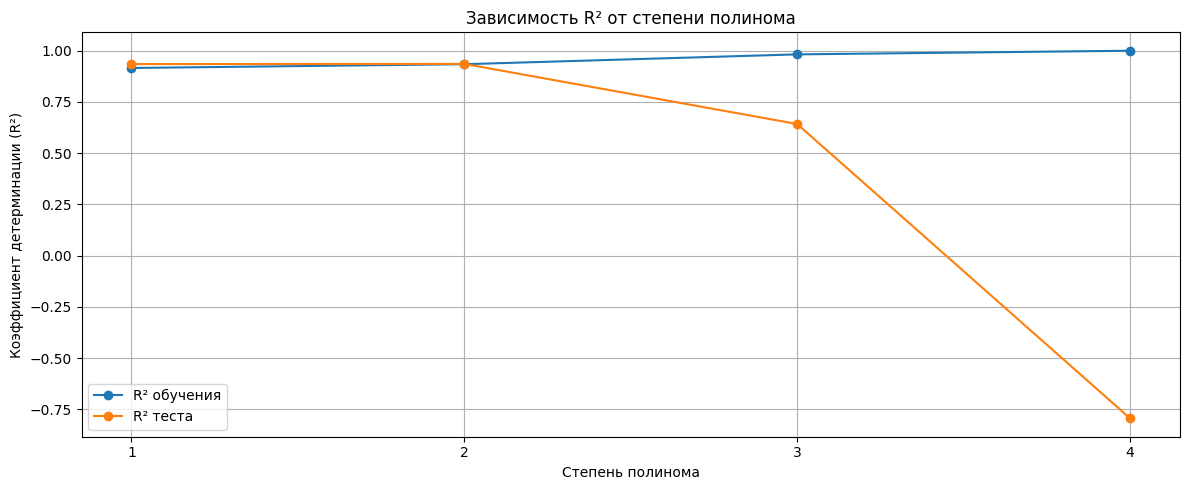

In [7]:
plt.figure(figsize=(12, 5))
plt.plot(results_df['degree'], results_df['train_r2'], marker='o', label='R² обучения')
plt.plot(results_df['degree'], results_df['test_r2'], marker='o', label='R² теста')
plt.xlabel('Степень полинома')
plt.ylabel('Коэффициент детерминации (R²)')
plt.title('Зависимость R² от степени полинома')
plt.xticks(degrees)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
best_degree_r2 = results_df.loc[results_df['test_r2'].idxmax()]
best_degree_mse = results_df.loc[results_df['test_mse'].idxmin()]

print(f"Лучшая степень по максимальному R² на тесте: {int(best_degree_r2['degree'])} (R² = {best_degree_r2['test_r2']:.4f})")
print(f"Лучшая степень по минимальной MSE на тесте: {int(best_degree_mse['degree'])} (MSE = {best_degree_mse['test_mse']:.4f})")

Лучшая степень по максимальному R² на тесте: 2 (R² = 0.9356)
Лучшая степень по минимальной MSE на тесте: 2 (MSE = 0.0116)


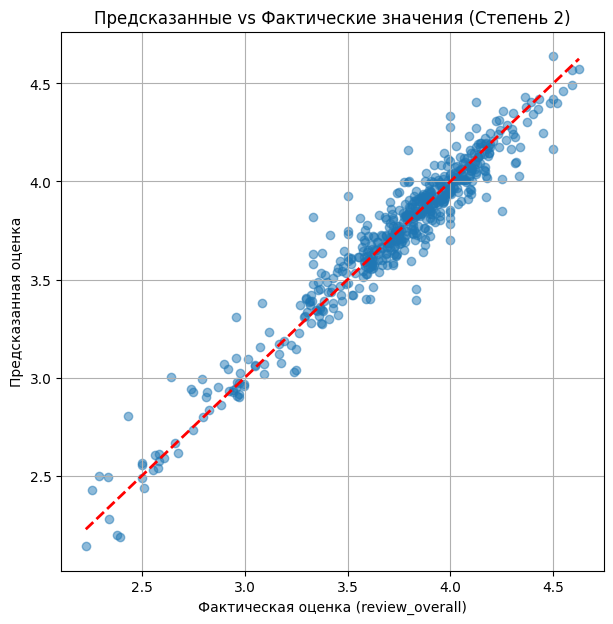

In [9]:
best_model_pipeline = results_df.loc[results_df['test_r2'].idxmax()]['model']
y_pred_best = best_model_pipeline.predict(X_test)

plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Фактическая оценка (review_overall)")
plt.ylabel("Предсказанная оценка")
plt.title(f"Предсказанные vs Фактические значения (Степень {int(best_degree_r2['degree'])})")
plt.grid(True)
plt.show()

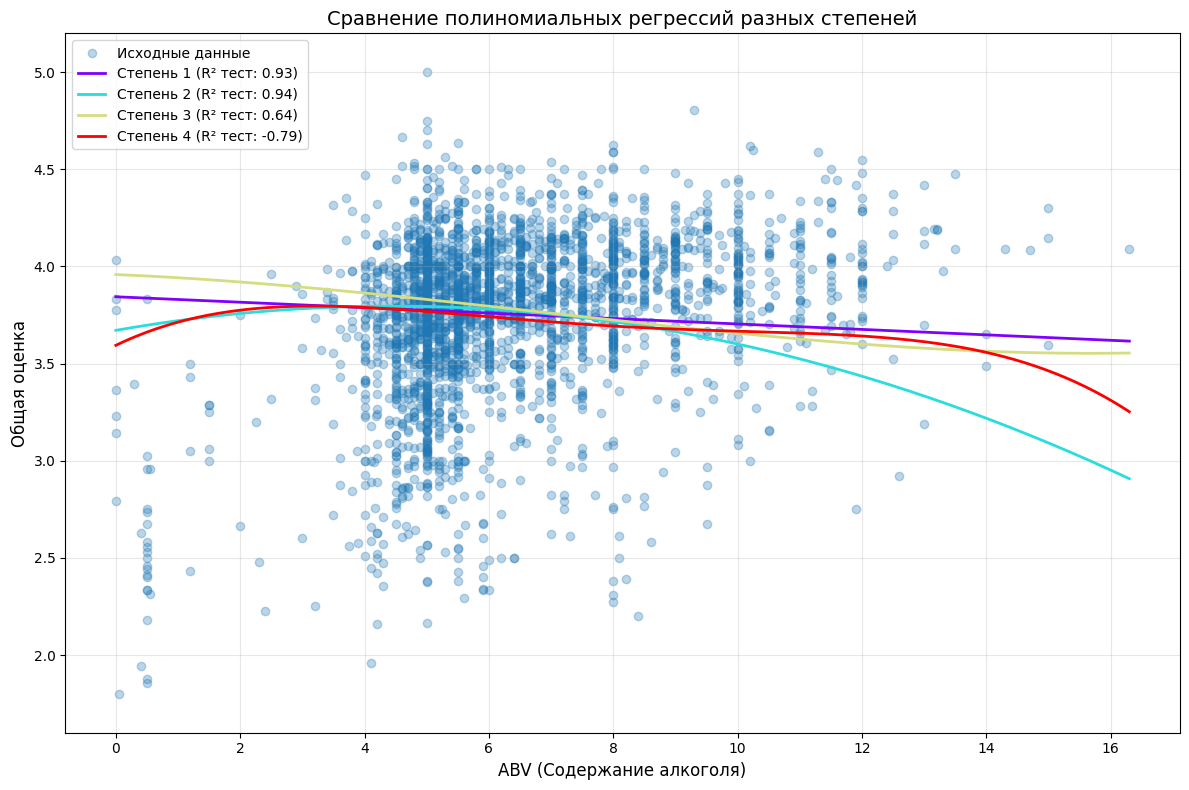

In [ ]:
min_abv = X_filtered['ABV'].min()
max_abv = X_filtered['ABV'].max()
abv_range = np.linspace(min_abv, max_abv, 300).reshape(-1, 1)

plt.figure(figsize=(12, 8))
plt.scatter(X_filtered['ABV'], y_filtered, alpha=0.3, label='Исходные данные')

colors = plt.cm.rainbow(np.linspace(0, 1, len(degrees)))

for idx, degree in enumerate(degrees):
    model_info = results_df.iloc[idx]
    model_pipeline = model_info['model']
    
    scaler = model_pipeline.named_steps['scaler']
    poly_features = model_pipeline.named_steps['poly_features']
    lin_reg = model_pipeline.named_steps['lin_reg']
    
    X_plot_dummy = pd.DataFrame(
        np.tile(X_train.mean().values, (abv_range.shape[0], 1)),
        columns=X_train.columns
    )
    X_plot_dummy['ABV'] = abv_range.ravel()
    
    X_plot_scaled = scaler.transform(X_plot_dummy)
    X_plot_poly = poly_features.transform(X_plot_scaled)
    
    y_pred_curve = lin_reg.predict(X_plot_poly)
    
    sort_order = np.argsort(abv_range.ravel())
    plt.plot(
        abv_range.ravel()[sort_order], 
        y_pred_curve[sort_order],
        color=colors[idx],
        linewidth=2,
        label=f'Степень {degree} (R² тест: {model_info["test_r2"]:.2f})'
    )

plt.xlabel("ABV (Содержание алкоголя)", fontsize=12)
plt.ylabel("Общая оценка", fontsize=12)
plt.title("Сравнение полиномиальных регрессий разных степеней", fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)
plt.ylim(y_filtered.min()-0.2, y_filtered.max()+0.2)
plt.tight_layout()
plt.show()